In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [2]:
def clean(features, data):
    choose = np.array([True] * len(data))
    for feature in features:
        z_score = stats.zscore(data[feature])
        z_score = np.abs(z_score) < 3
        choose = choose & z_score
    data_clean = data[choose]
    return data_clean


df = pd.read_csv('data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by=['row', 'col'], ascending=[True, True]).reset_index(drop=True)

df['AWS2'] = df['AWS']

features = [
    'AWS2', 'CAPE', 'V850', 'EWSS', 'KX', 'U250', 'U850', 'CIN', 'V250', 'R250',
    'hour_sin','hour_cos','doy_sin','doy_cos'
]
target = 'AWS'

df = clean(features[0:10],df)

df['year'] = df['datetime'].dt.year
df['hour'] = df['datetime'].dt.hour
df['doy']  = df['datetime'].dt.dayofyear
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['doy_sin']  = np.sin(2 * np.pi * df['doy']  / 365)
df['doy_cos']  = np.cos(2 * np.pi * df['doy']  / 365)


In [3]:
split_time = pd.Timestamp('2020-10-15 23:00:00')
df_train = df[df['datetime'] <= split_time].reset_index(drop=True)
df_test  = df[df['datetime'] >  split_time].reset_index(drop=True)

df_test_orig = df_test.copy()

scaler = StandardScaler()
df_train[features] = scaler.fit_transform(df_train[features])
df_test[features]  = scaler.transform(df_test[features])


In [4]:
def make_sequences(data, feats, tgt, window_size, horizon):
    X, y = [], []
    arr_f = data[feats].values
    arr_t = data[tgt].values
    times = data['datetime'].tolist()
    for i in range(window_size, len(data) - horizon + 1):
        if any((times[j] - times[j-1]).total_seconds() != 3600 
               for j in range(i-window_size+1, i+horizon)):
            continue
        X.append(arr_f[i-window_size:i])
        y.append(arr_t[i:i+horizon])
    return np.array(X), np.array(y)

window_size = 2
horizon     = 6

X_train, y_train = make_sequences(df_train, features, target, window_size, horizon)
X_test,  y_test  = make_sequences(df_test,  features, target, window_size, horizon)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test  shapes:", X_test.shape,  y_test.shape)

Train shapes: (337904, 2, 14) (337904, 6)
Test  shapes: (71896, 2, 14) (71896, 6)


Reloading Tuner from rs_lstm\lstm_rs\tuner0.json


C:\Users\giakh\AppData\Local\Temp\ipykernel_20804\3643567333.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters found:
  units1   = 128
  units2   = 64
  dropout1 = 0.30
  dropout2 = 0.20
  lr       = 0.0001
Epoch 1/100
8448/8448 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step - loss: 0.1419 - mae: 0.1240 - val_loss: 0.2332 - val_mae: 0.1572
Epoch 2/100
8448/8448 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 0.1298 - mae: 0.1073 - val_loss: 0.2496 - val_mae: 0.1701
Epoch 3/100
8448/8448 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 0.1313 - mae: 0.1074 - val_loss: 0.2447 - val_mae: 0.1603
Epoch 4/100
8448/8448 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 0.1287 - mae: 0.1057 - val_loss: 0.2569 - val_mae: 0.1614
Epoch 5/100
8448/8448 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.1283 - mae: 0.1050 - val_loss: 0.2622 - val_mae: 0.1680
Epoch 6/100
8448/8448 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 0.1242 - mae: 0.1030 - val_loss: 0.3154 - val_mae: 0.1874
Epoch 7/100
8448/8448 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 0.1260 - mae: 0.1047 - val_loss: 0.3074 - val_mae: 0.1803
Epoch 8/100
8448/8448 ━━━━━━━

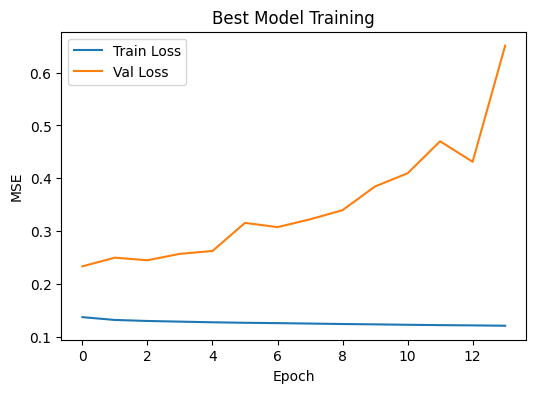

In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


def build_stacked_lstm(window_size, n_features, horizon,
                       units1, units2, dropout1, dropout2, lr):
    model = Sequential()
    # LSTM layer 1
    model.add(LSTM(units1,
                   return_sequences=True,
                   input_shape=(window_size, n_features)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout1))
    # LSTM layer 2
    model.add(LSTM(units2, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(dropout2))
    # Dense output
    model.add(Dense(horizon, activation='linear'))
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model


def build_model_hp(hp):
    return build_stacked_lstm(
        window_size=window_size,
        n_features=len(features),
        horizon=horizon,
        units1=hp.Choice('units1', [64, 128, 256]),
        units2=hp.Choice('units2', [32, 64, 128, 256]),
        dropout1=hp.Float('dropout1', 0.1, 0.5, step=0.1),
        dropout2=hp.Float('dropout2', 0.1, 0.5, step=0.1),
        lr=hp.Choice('lr', [1e-2, 1e-3, 1e-4])
    )

tuner = RandomSearch(
    build_model_hp,
    objective='val_loss',       
    max_trials=20,             
    executions_per_trial=1,
    directory='rs_lstm',
    project_name='lstm_rs'
)


tuner.search(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    verbose=1
)


best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.get_best_models(num_models=1)[0]

print("Best hyperparameters found:")
print(f"  units1   = {best_hp.get('units1')}")
print(f"  units2   = {best_hp.get('units2')}")
print(f"  dropout1 = {best_hp.get('dropout1'):.2f}")
print(f"  dropout2 = {best_hp.get('dropout2'):.2f}")
print(f"  lr       = {best_hp.get('lr')}")

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=13, restore_best_weights=True)
    ],
    verbose=1
)


plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],  label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Best Model Training')
plt.legend()
plt.show()


In [6]:
model.save('best_stacked_lstm_model_final.h5')
print("Saved!")

Saved!


In [7]:
from scipy.stats import pearsonr

y_pred = model.predict(X_test)         
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test MSE  : {mse:.4f}")
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MAE  : {mae:.4f}")
print(f"Test R^2  : {r2:.4f}")


y_true_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()
pearson_r, p_value = pearsonr(y_true_flat, y_pred_flat)
print(f"Overall Pearson R: {pearson_r:.4f}")


2247/2247 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Test MSE  : 0.2894
Test RMSE : 0.5380
Test MAE  : 0.2106
Test R^2  : 0.3251
Overall Pearson R: 0.5755


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

C:\Users\giakh\AppData\Local\Temp\ipykernel_20804\1203393298.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


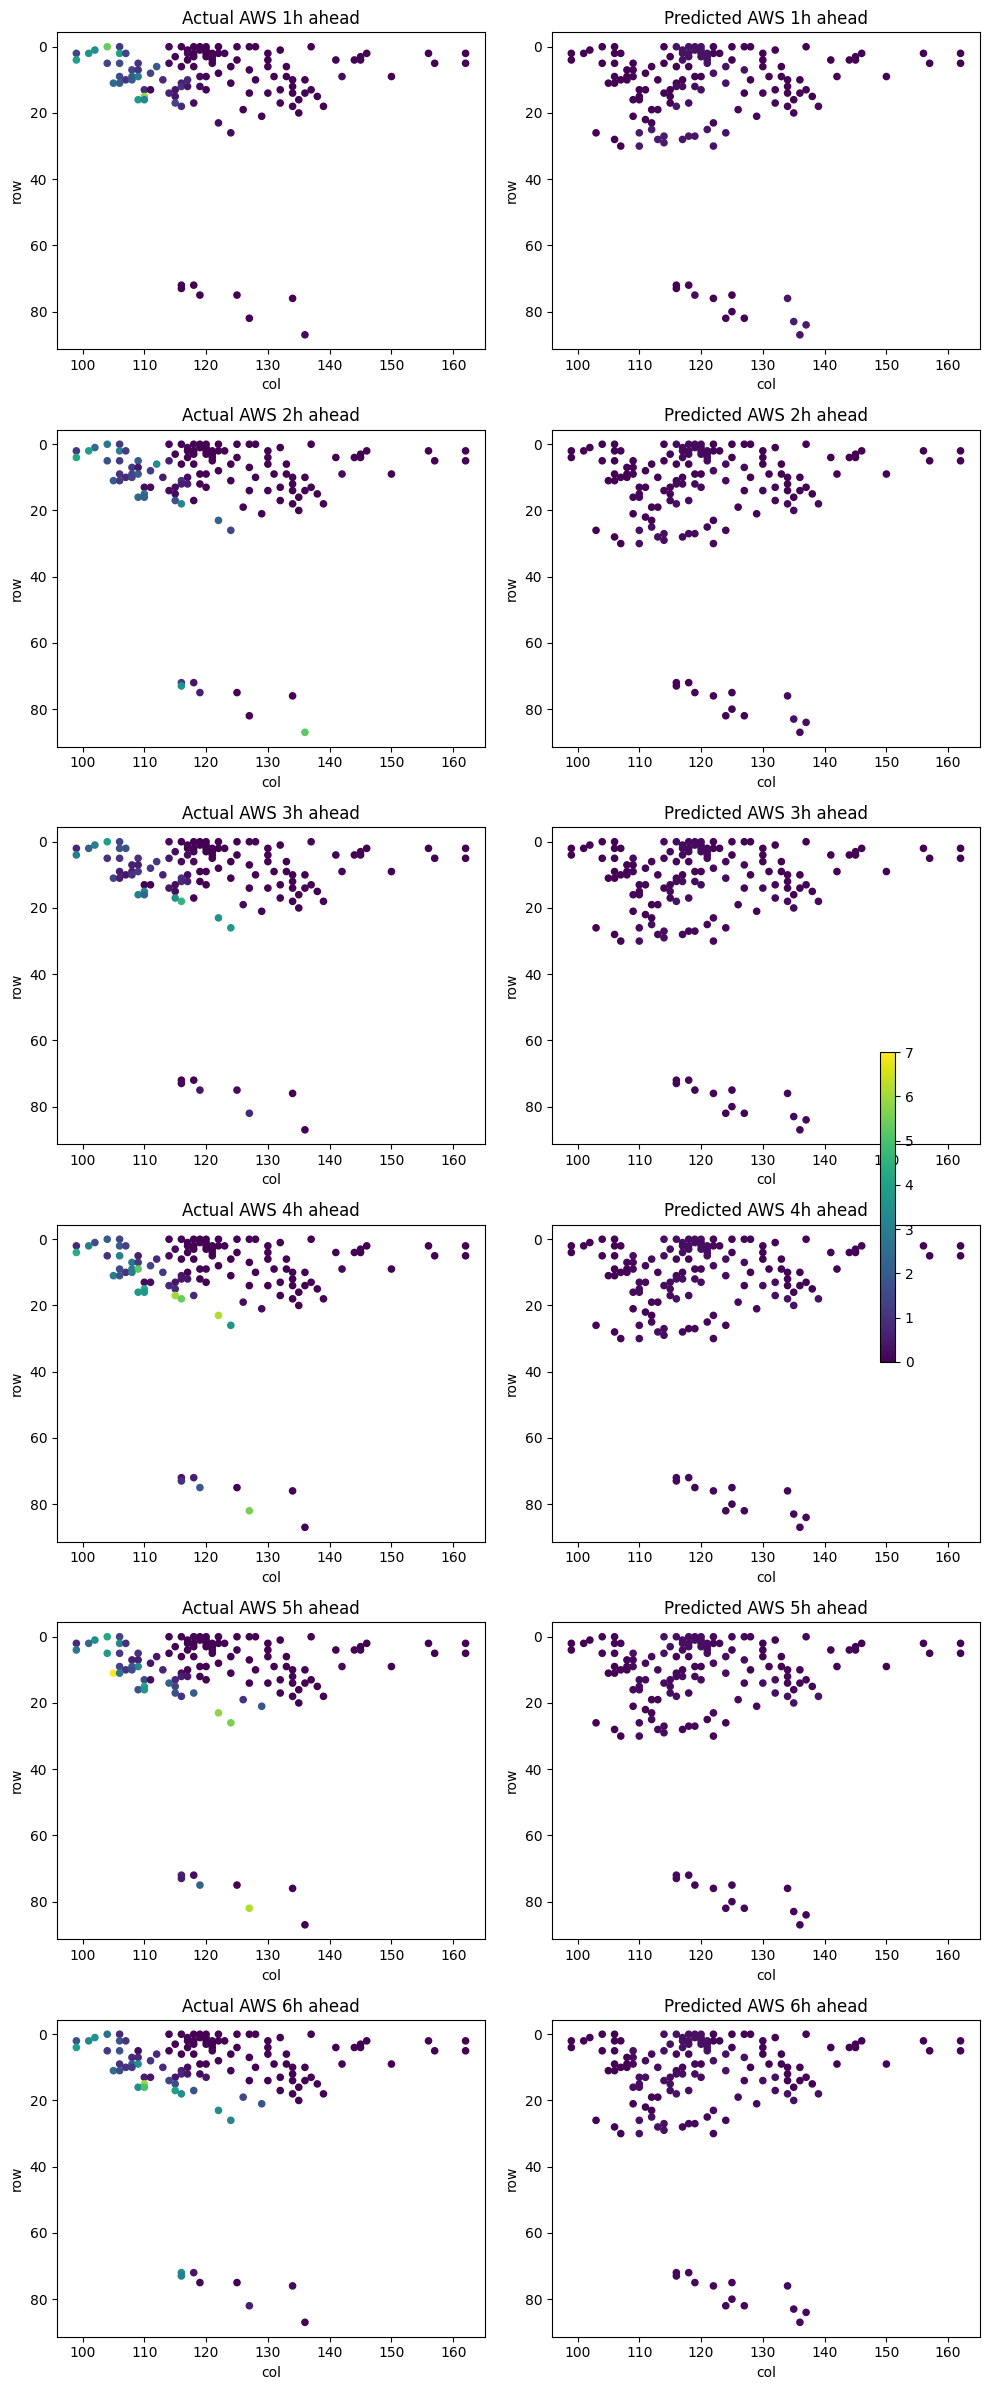

In [8]:
from datetime import timedelta


test_day   = pd.to_datetime('2020-10-29 09:00')
prev_times = [test_day - timedelta(hours=i) for i in range(window_size, 0, -1)]


coord_cols = ['row', 'col']
df2020     = df[df['datetime'].dt.year == 2020].copy()
grid       = df2020[coord_cols].drop_duplicates().reset_index(drop=True)
nP         = len(grid)
pred_map = np.full((horizon, nP), np.nan)
act_map  = np.full((horizon, nP), np.nan)

for idx, pt in grid.iterrows():
    cond   = (df2020['row']==pt['row']) & (df2020['col']==pt['col'])
    df_loc = df2020[cond].sort_values('datetime').reset_index(drop=True)
    df_win = df_loc[df_loc['datetime'].isin(prev_times)]
    if len(df_win) != window_size:
        continue
    
    
    Xd    = df_win[features].values.reshape(1, window_size, len(features))
    y_l   = model.predict(Xd).flatten()      
    pred_map[:, idx] = y_l
    
    df_act = df_loc[
        (df_loc['datetime'] >= test_day) &
        (df_loc['datetime'] <  test_day + timedelta(hours=horizon))
    ].sort_values('datetime')
    if len(df_act) != horizon:
        continue
    act_map[:, idx] = df_act[target].values

print(f"Built maps for {nP} points.")

vmin = np.nanmin(act_map)
vmax = np.nanmax(act_map)

fig, axes = plt.subplots(nrows=horizon, ncols=2, figsize=(10, 4*horizon))
for h in range(horizon):
    ax1, ax2 = axes[h]
    sc1 = ax1.scatter(
        grid['col'], grid['row'], c=act_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax1.set_title(f'Actual AWS {h+1}h ahead')
    ax1.invert_yaxis()
    ax1.set_xlabel('col'); ax1.set_ylabel('row')

    sc2 = ax2.scatter(
        grid['col'], grid['row'], c=pred_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax2.set_title(f'Predicted AWS {h+1}h ahead')
    ax2.invert_yaxis()
    ax2.set_xlabel('col'); ax2.set_ylabel('row')

fig.colorbar(sc1, ax=axes, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()
